In [39]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/uber-ride-analytics-dashboard/ncr_ride_bookings.csv
/kaggle/input/uber-ride-analytics-dashboard/Dasboard.gif
/kaggle/input/uber-ride-analytics-dashboard/Uber.pbix


In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.figure_factory as ff
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Make our plots look nice
plt.style.use('default')
sns.set_palette("husl")
pd.set_option('display.max_columns', None)

print("🚀 Libraries loaded successfully!")

🚀 Libraries loaded successfully!


In [41]:
# Load the dataset
df = pd.read_csv("/kaggle/input/uber-ride-analytics-dashboard/ncr_ride_bookings.csv")

In [42]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 21 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   Date                               150000 non-null  object 
 1   Time                               150000 non-null  object 
 2   Booking ID                         150000 non-null  object 
 3   Booking Status                     150000 non-null  object 
 4   Customer ID                        150000 non-null  object 
 5   Vehicle Type                       150000 non-null  object 
 6   Pickup Location                    150000 non-null  object 
 7   Drop Location                      150000 non-null  object 
 8   Avg VTAT                           139500 non-null  float64
 9   Avg CTAT                           102000 non-null  float64
 10  Cancelled Rides by Customer        10500 non-null   float64
 11  Reason for cancelling by Customer  1050

In [43]:
print(df.shape)
print(len(df))

(150000, 21)
150000


In [44]:
#print(df.head())
df.head()

,Date,Time,Booking ID,Booking Status,Customer ID,Vehicle Type,Pickup Location,Drop Location,Avg VTAT,Avg CTAT,Cancelled Rides by Customer,Reason for cancelling by Customer,Cancelled Rides by Driver,Driver Cancellation Reason,Incomplete Rides,Incomplete Rides Reason,Booking Value,Ride Distance,Driver Ratings,Customer Rating,Payment Method
0,2024-03-23,12:29:38,"""CNR5884300""",No Driver Found,"""CID1982111""",eBike,Palam Vihar,Jhilmil,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2024-11-29,18:01:39,"""CNR1326809""",Incomplete,"""CID4604802""",Go Sedan,Shastri Nagar,Gurgaon Sector 56,4.9,14.0,NaN,NaN,NaN,NaN,1.0,Vehicle Breakdown,237.0,5.73,NaN,NaN,UPI
2,2024-08-23,08:56:10,"""CNR8494506""",Completed,"""CID9202816""",Auto,Khandsa,Malviya Nagar,13.4,25.8,NaN,NaN,NaN,NaN,NaN,NaN,627.0,13.58,4.9,4.9,Debit Card
3,2024-10-21,17:17:25,"""CNR8906825""",Completed,"""CID2610914""",Premier Sedan,Central Secretariat,Inderlok,13.1,28.5,NaN,NaN,NaN,NaN,NaN,NaN,416.0,34.02,4.6,5.0,UPI
4,2024-09-16,22:08:00,"""CNR1950162""",Completed,"""CID9933542""",Bike,Ghitorni Village,Khan Market,5.3,19.6,NaN,NaN,NaN,NaN,NaN,NaN,737.0,48.21,4.1,4.3,UPI


In [45]:
print({df['Date'].min()}, {df['Date'].max()})

{'2024-01-01'} {'2024-12-30'}


In [46]:
print(df['Vehicle Type'].nunique())

7


In [47]:
print(df['Vehicle Type'].value_counts())

Vehicle Type
Auto             37419
Go Mini          29806
Go Sedan         27141
Bike             22517
Premier Sedan    18111
eBike            10557
Uber XL           4449
Name: count, dtype: int64


In [48]:
print(df['Customer ID'].nunique())

148788


In [49]:
print(df['Booking Status'].value_counts())

Booking Status
Completed                93000
Cancelled by Driver      27000
No Driver Found          10500
Cancelled by Customer    10500
Incomplete                9000
Name: count, dtype: int64


In [50]:
"""Lets clean and prepare our data for analysis"""
def clean_and_prepare_data(df):
    # Make copy to avoid modify originals
    df_clean=df.copy()
 # Convert dates and times
    df_clean['Date'] = pd.to_datetime(df_clean['Date'])
    df_clean['DateTime'] = pd.to_datetime(df_clean['Date'].astype(str) + ' ' + df_clean['Time'].astype(str))

     # Extract time features
    df_clean['Hour'] = df_clean['DateTime'].dt.hour
    df_clean['DayOfWeek'] = df_clean['DateTime'].dt.day_name()
    df_clean['Month'] = df_clean['DateTime'].dt.month
    df_clean['IsWeekend'] = df_clean['DateTime'].dt.weekday >= 5

    # Clean numeric columns
    numeric_cols = ['Booking Value', 'Ride Distance', 'Driver Ratings', 'Customer Rating']
    for col in numeric_cols:
        df_clean[col] = pd.to_numeric(df_clean[col], errors='coerce')
    
    # Create helpful flags
    df_clean['Is_Successful'] = df_clean['Booking Status'] == 'Completed'
    df_clean['Is_Cancelled_Customer'] = df_clean['Cancelled Rides by Customer'].notna()
    df_clean['Is_Cancelled_Driver'] = df_clean['Cancelled Rides by Driver'].notna()
    
    # Categorize booking status
    def categorize_status(status):
        if status == 'Completed':
            return 'Completed'
        elif 'Cancelled' in str(status):
            return 'Cancelled'
        elif status == 'No Driver Found':
            return 'No Driver Found'
        else:
            return 'Other'
    
    df_clean['Status_Category'] = df_clean['Booking Status'].apply(categorize_status)
    
    return df_clean

# Clean our data
df = clean_and_prepare_data(df)
print("🔧 Data cleaning completed!")
print(f"✅ Ready for analysis with {len(df)} rides")

🔧 Data cleaning completed!
✅ Ready for analysis with 150000 rides


In [51]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 30 columns):
 #   Column                             Non-Null Count   Dtype         
---  ------                             --------------   -----         
 0   Date                               150000 non-null  datetime64[ns]
 1   Time                               150000 non-null  object        
 2   Booking ID                         150000 non-null  object        
 3   Booking Status                     150000 non-null  object        
 4   Customer ID                        150000 non-null  object        
 5   Vehicle Type                       150000 non-null  object        
 6   Pickup Location                    150000 non-null  object        
 7   Drop Location                      150000 non-null  object        
 8   Avg VTAT                           139500 non-null  float64       
 9   Avg CTAT                           102000 non-null  float64       
 10  Cancelled Rides by C

In [52]:
df.head()

,Date,Time,Booking ID,Booking Status,Customer ID,Vehicle Type,Pickup Location,Drop Location,Avg VTAT,Avg CTAT,Cancelled Rides by Customer,Reason for cancelling by Customer,Cancelled Rides by Driver,Driver Cancellation Reason,Incomplete Rides,Incomplete Rides Reason,Booking Value,Ride Distance,Driver Ratings,Customer Rating,Payment Method,DateTime,Hour,DayOfWeek,Month,IsWeekend,Is_Successful,Is_Cancelled_Customer,Is_Cancelled_Driver,Status_Category
0,2024-03-23,12:29:38,"""CNR5884300""",No Driver Found,"""CID1982111""",eBike,Palam Vihar,Jhilmil,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2024-03-23 12:29:38,12,Saturday,3,True,False,False,False,No Driver Found
1,2024-11-29,18:01:39,"""CNR1326809""",Incomplete,"""CID4604802""",Go Sedan,Shastri Nagar,Gurgaon Sector 56,4.9,14.0,NaN,NaN,NaN,NaN,1.0,Vehicle Breakdown,237.0,5.73,NaN,NaN,UPI,2024-11-29 18:01:39,18,Friday,11,False,False,False,False,Other
2,2024-08-23,08:56:10,"""CNR8494506""",Completed,"""CID9202816""",Auto,Khandsa,Malviya Nagar,13.4,25.8,NaN,NaN,NaN,NaN,NaN,NaN,627.0,13.58,4.9,4.9,Debit Card,2024-08-23 08:56:10,8,Friday,8,False,True,False,False,Completed
3,2024-10-21,17:17:25,"""CNR8906825""",Completed,"""CID2610914""",Premier Sedan,Central Secretariat,Inderlok,13.1,28.5,NaN,NaN,NaN,NaN,NaN,NaN,416.0,34.02,4.6,5.0,UPI,2024-10-21 17:17:25,17,Monday,10,False,True,False,False,Completed
4,2024-09-16,22:08:00,"""CNR1950162""",Completed,"""CID9933542""",Bike,Ghitorni Village,Khan Market,5.3,19.6,NaN,NaN,NaN,NaN,NaN,NaN,737.0,48.21,4.1,4.3,UPI,2024-09-16 22:08:00,22,Monday,9,False,True,False,False,Completed


In [53]:
df.columns

Index(['Date', 'Time', 'Booking ID', 'Booking Status', 'Customer ID',
       'Vehicle Type', 'Pickup Location', 'Drop Location', 'Avg VTAT',
       'Avg CTAT', 'Cancelled Rides by Customer',
       'Reason for cancelling by Customer', 'Cancelled Rides by Driver',
       'Driver Cancellation Reason', 'Incomplete Rides',
       'Incomplete Rides Reason', 'Booking Value', 'Ride Distance',
       'Driver Ratings', 'Customer Rating', 'Payment Method', 'DateTime',
       'Hour', 'DayOfWeek', 'Month', 'IsWeekend', 'Is_Successful',
       'Is_Cancelled_Customer', 'Is_Cancelled_Driver', 'Status_Category'],
      dtype='object')

🚕 Top 10 Pickup Locations:
Pickup Location
Khandsa             949
Barakhamba Road     946
Saket               931
Badarpur            921
Pragati Maidan      920
Madipur             919
AIIMS               918
Mehrauli            915
Dwarka Sector 21    914
Pataudi Chowk       907
Name: count, dtype: int64


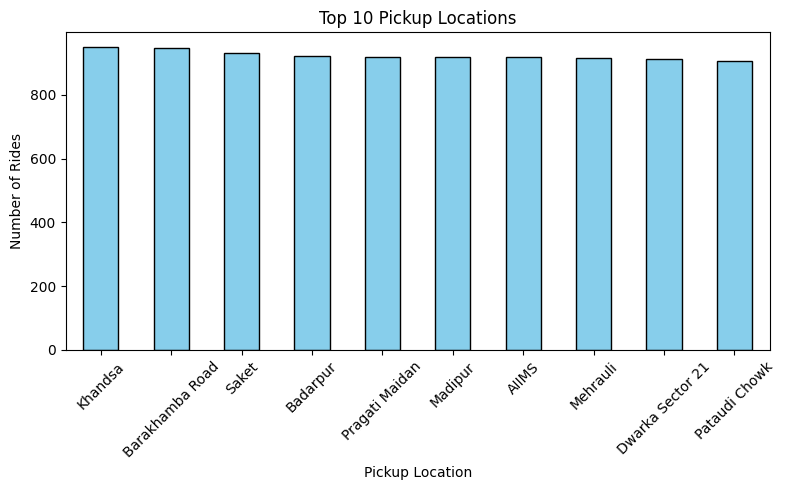


📍 Top 10 Drop Locations:
Drop Location
Ashram                936
Basai Dhankot         917
Lok Kalyan Marg       916
Narsinghpur           913
Cyber Hub             912
Kalkaji               912
Kashmere Gate ISBT    909
Udyog Vihar           906
Lajpat Nagar          904
Nehru Place           902
Name: count, dtype: int64


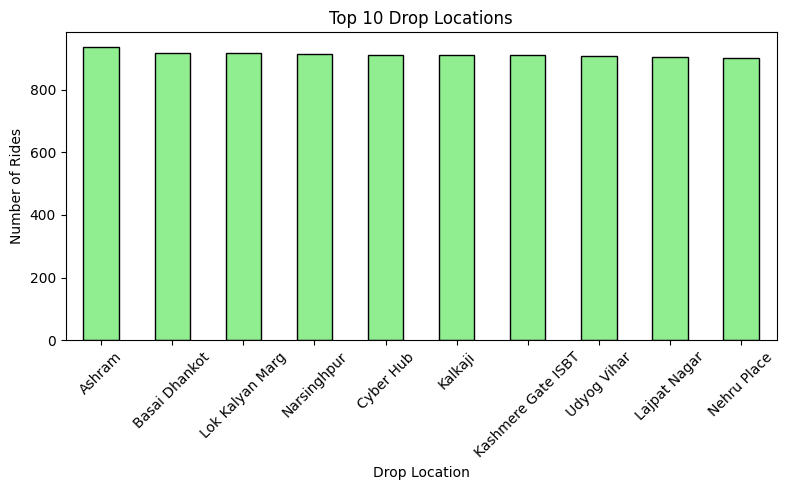


📊 Summary of Top Locations:
        Top Pickups  Pickup Count           Top Drops  Drop Count
0           Khandsa           949              Ashram         936
1   Barakhamba Road           946       Basai Dhankot         917
2             Saket           931     Lok Kalyan Marg         916
3          Badarpur           921         Narsinghpur         913
4    Pragati Maidan           920           Cyber Hub         912
5           Madipur           919             Kalkaji         912
6             AIIMS           918  Kashmere Gate ISBT         909
7          Mehrauli           915         Udyog Vihar         906
8  Dwarka Sector 21           914        Lajpat Nagar         904
9     Pataudi Chowk           907         Nehru Place         902


In [54]:
# 🔍 Find Top 5 Pickup & Drop Locations

# Top 5 pickups
top_pickups = df['Pickup Location'].value_counts().head(10)
print("🚕 Top 10 Pickup Locations:")
print(top_pickups)

plt.figure(figsize=(8,5))
top_pickups.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title("Top 10 Pickup Locations")
plt.xlabel("Pickup Location")
plt.ylabel("Number of Rides")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Top 5 drops
top_drops = df['Drop Location'].value_counts().head(10)
print("\n📍 Top 10 Drop Locations:")
print(top_drops)

plt.figure(figsize=(8,5))
top_drops.plot(kind='bar', color='lightgreen', edgecolor='black')
plt.title("Top 10 Drop Locations")
plt.xlabel("Drop Location")
plt.ylabel("Number of Rides")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Merge into one summary table

summary = pd.DataFrame({
    "Top Pickups": top_pickups.index,
    "Pickup Count": top_pickups.values,
    "Top Drops": top_drops.index,
    "Drop Count": top_drops.values
})

print("\n📊 Summary of Top Locations:")
print(summary)


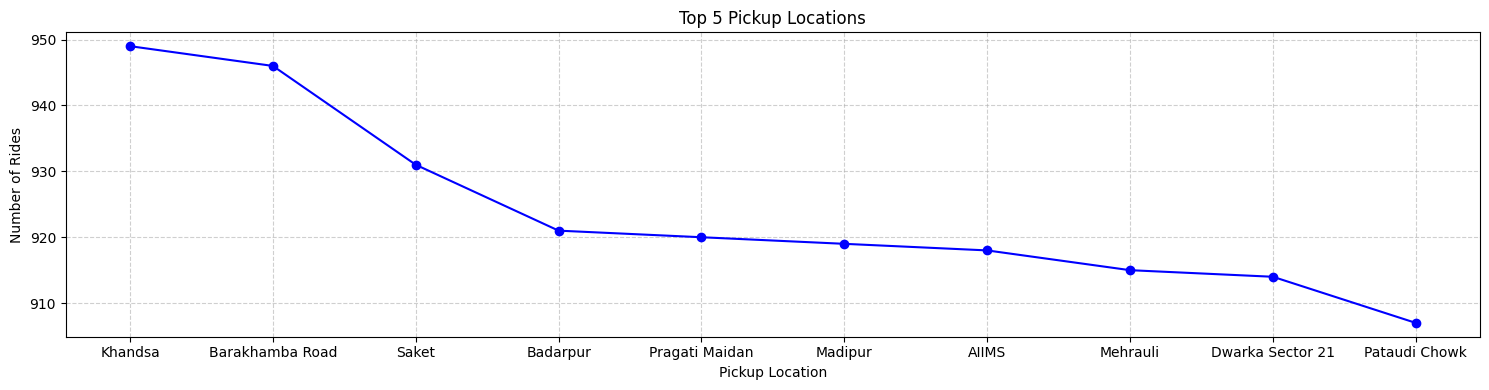

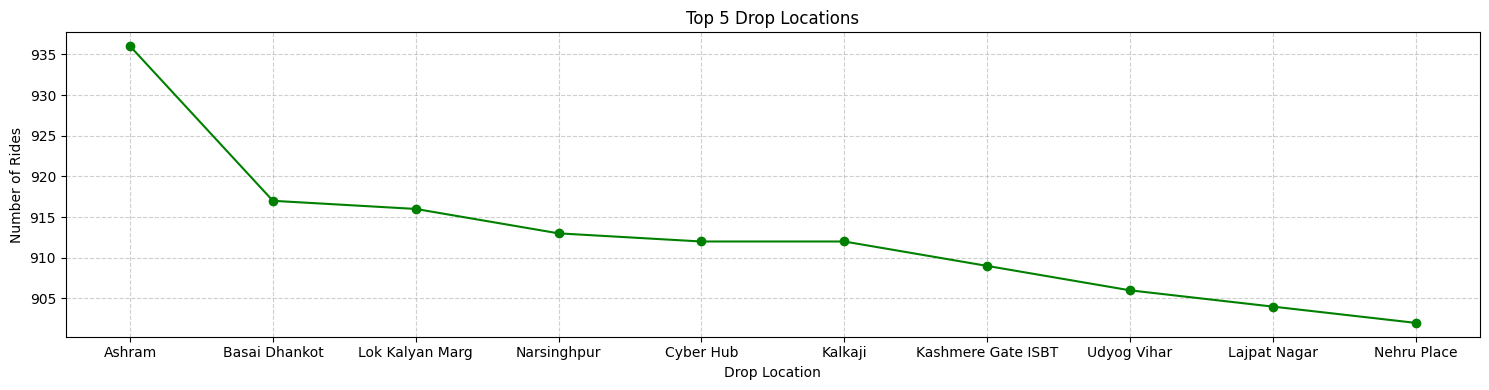

In [55]:
plt.figure(figsize=(15,4))
plt.plot(top_pickups.index, top_pickups.values, marker='o', linestyle='-', color='blue')
plt.title("Top 5 Pickup Locations")
plt.xlabel("Pickup Location")
plt.ylabel("Number of Rides")
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

# -------------------------------
# 📍 Top 5 Drop Locations - Line Plot
# -------------------------------
plt.figure(figsize=(15,4))
plt.plot(top_drops.index, top_drops.values, marker='o', linestyle='-', color='green')
plt.title("Top 5 Drop Locations")
plt.xlabel("Drop Location")
plt.ylabel("Number of Rides")
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()


In [56]:
df.isnull().sum()

Date                                      0
Time                                      0
Booking ID                                0
Booking Status                            0
Customer ID                               0
Vehicle Type                              0
Pickup Location                           0
Drop Location                             0
Avg VTAT                              10500
Avg CTAT                              48000
Cancelled Rides by Customer          139500
Reason for cancelling by Customer    139500
Cancelled Rides by Driver            123000
Driver Cancellation Reason           123000
Incomplete Rides                     141000
Incomplete Rides Reason              141000
Booking Value                         48000
Ride Distance                         48000
Driver Ratings                        57000
Customer Rating                       57000
Payment Method                        48000
DateTime                                  0
Hour                            

🔍 Missing Data Analysis:
                                   Missing Count  Percentage
Incomplete Rides Reason                   141000        94.0
Incomplete Rides                          141000        94.0
Reason for cancelling by Customer         139500        93.0
Cancelled Rides by Customer               139500        93.0
Cancelled Rides by Driver                 123000        82.0
Driver Cancellation Reason                123000        82.0
Customer Rating                            57000        38.0
Driver Ratings                             57000        38.0
Ride Distance                              48000        32.0
Booking Value                              48000        32.0
Payment Method                             48000        32.0
Avg CTAT                                   48000        32.0
Avg VTAT                                   10500         7.0


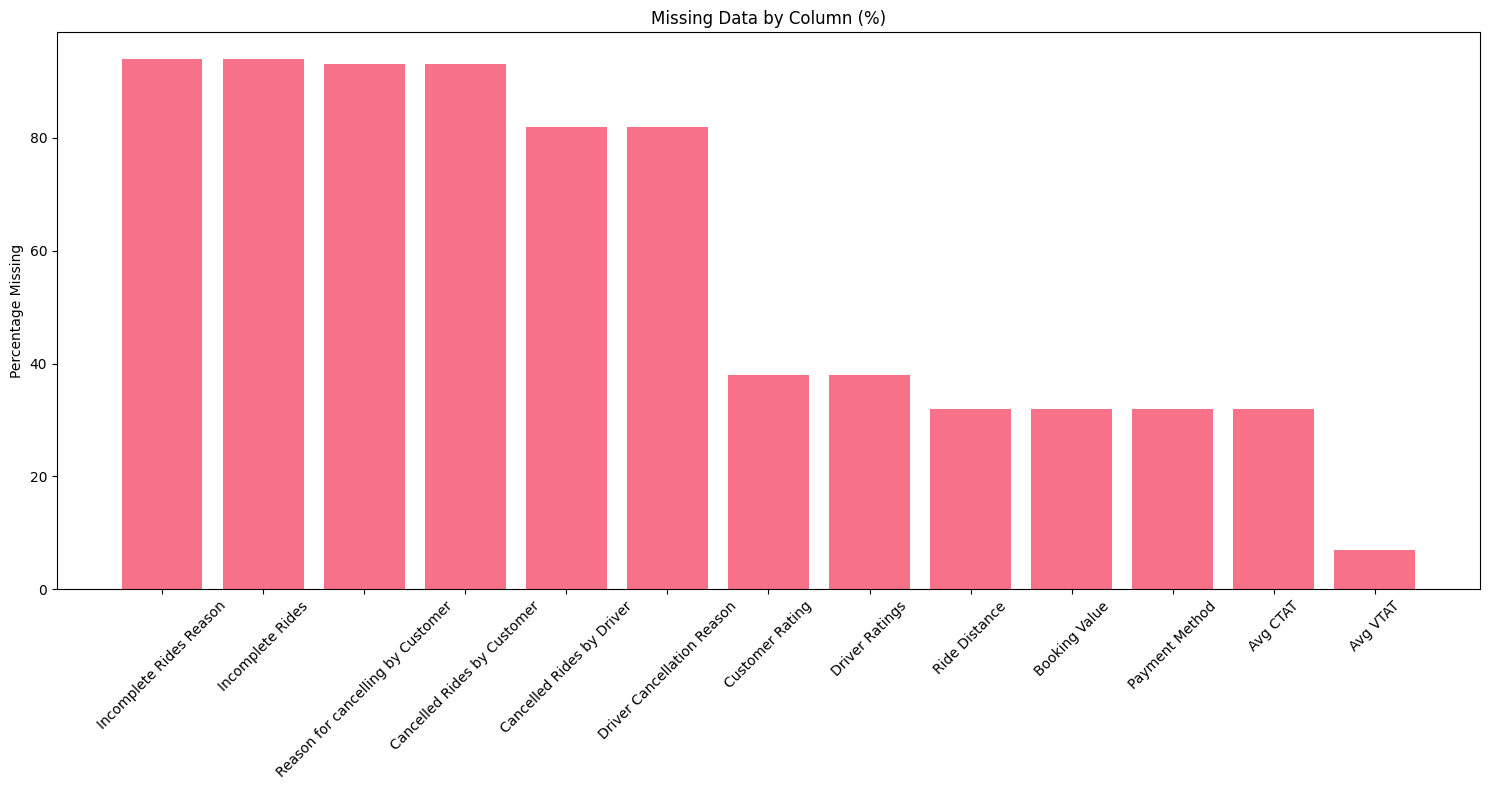

In [57]:
# Check for missing values
print("🔍 Missing Data Analysis:")
missing_data = df.isnull().sum()
missing_percentage = (missing_data / len(df)) * 100

missing_df = pd.DataFrame({
    'Missing Count': missing_data,
    'Percentage': missing_percentage
}).sort_values('Missing Count', ascending=False)

print(missing_df[missing_df['Missing Count'] > 0])

# Visualize missing data
plt.figure(figsize=(15, 8))
missing_cols = missing_df[missing_df['Missing Count'] > 0]
if len(missing_cols) > 0:
    # plt.plot(missing_cols.index, missing_cols.values, marker='o', linestyle='-', color='green')
    plt.bar(missing_cols.index, missing_cols['Percentage'])
    plt.title('Missing Data by Column (%)')
    plt.xticks(rotation=45)
    plt.ylabel('Percentage Missing')
    plt.tight_layout()
    plt.show()
else:
    print("🎉 No missing data found!")

In [58]:
# Create an executive summary
def create_executive_summary(df):
    """Generate key business metrics"""
    
    total_rides = len(df)
    successful_rides = df['Is_Successful'].sum()
    success_rate = (successful_rides / total_rides) * 100
    
    total_revenue = df[df['Is_Successful']]['Booking Value'].sum()
    avg_ride_value = df[df['Is_Successful']]['Booking Value'].mean()
    
    avg_distance = df[df['Is_Successful']]['Ride Distance'].mean()
    avg_driver_rating = df[df['Is_Successful']]['Driver Ratings'].mean()
    avg_customer_rating = df[df['Is_Successful']]['Customer Rating'].mean()
    
    # Cancellation analysis
    customer_cancellations = df['Is_Cancelled_Customer'].sum()
    driver_cancellations = df['Is_Cancelled_Driver'].sum()
    
    return {
        'total_rides': total_rides,
        'successful_rides': successful_rides,
        'success_rate': success_rate,
        'total_revenue': total_revenue,
        'avg_ride_value': avg_ride_value,
        'avg_distance': avg_distance,
        'avg_driver_rating': avg_driver_rating,
        'avg_customer_rating': avg_customer_rating,
        'customer_cancellations': customer_cancellations,
        'driver_cancellations': driver_cancellations
    }

metrics = create_executive_summary(df)

print(f" Total Rides Analyzed: {metrics['total_rides']:,}")
print(f" Successful Rides: {metrics['successful_rides']:,}")
print(f" Success Rate: {metrics['success_rate']:.1f}%")
print(f" Total Revenue: ₹{metrics['total_revenue']:,.0f}")
print(f" Avg Ride Value: ₹{metrics['avg_ride_value']:,.0f}")
print(f" Average Distance: {metrics['avg_distance']:.1f} km")
print(f" Avg Driver Rating: {metrics['avg_driver_rating']:.2f}/5")
print(f" Avg Customer Rating: {metrics['avg_customer_rating']:.2f}/5")
print(f" Customer Cancellations: {metrics['customer_cancellations']:,}")
print(f" Driver Cancellations: {metrics['driver_cancellations']:,}")

 Total Rides Analyzed: 150,000
 Successful Rides: 93,000
 Success Rate: 62.0%
 Total Revenue: ₹47,260,574
 Avg Ride Value: ₹508
 Average Distance: 26.0 km
 Avg Driver Rating: 4.23/5
 Avg Customer Rating: 4.40/5
 Customer Cancellations: 10,500
 Driver Cancellations: 27,000


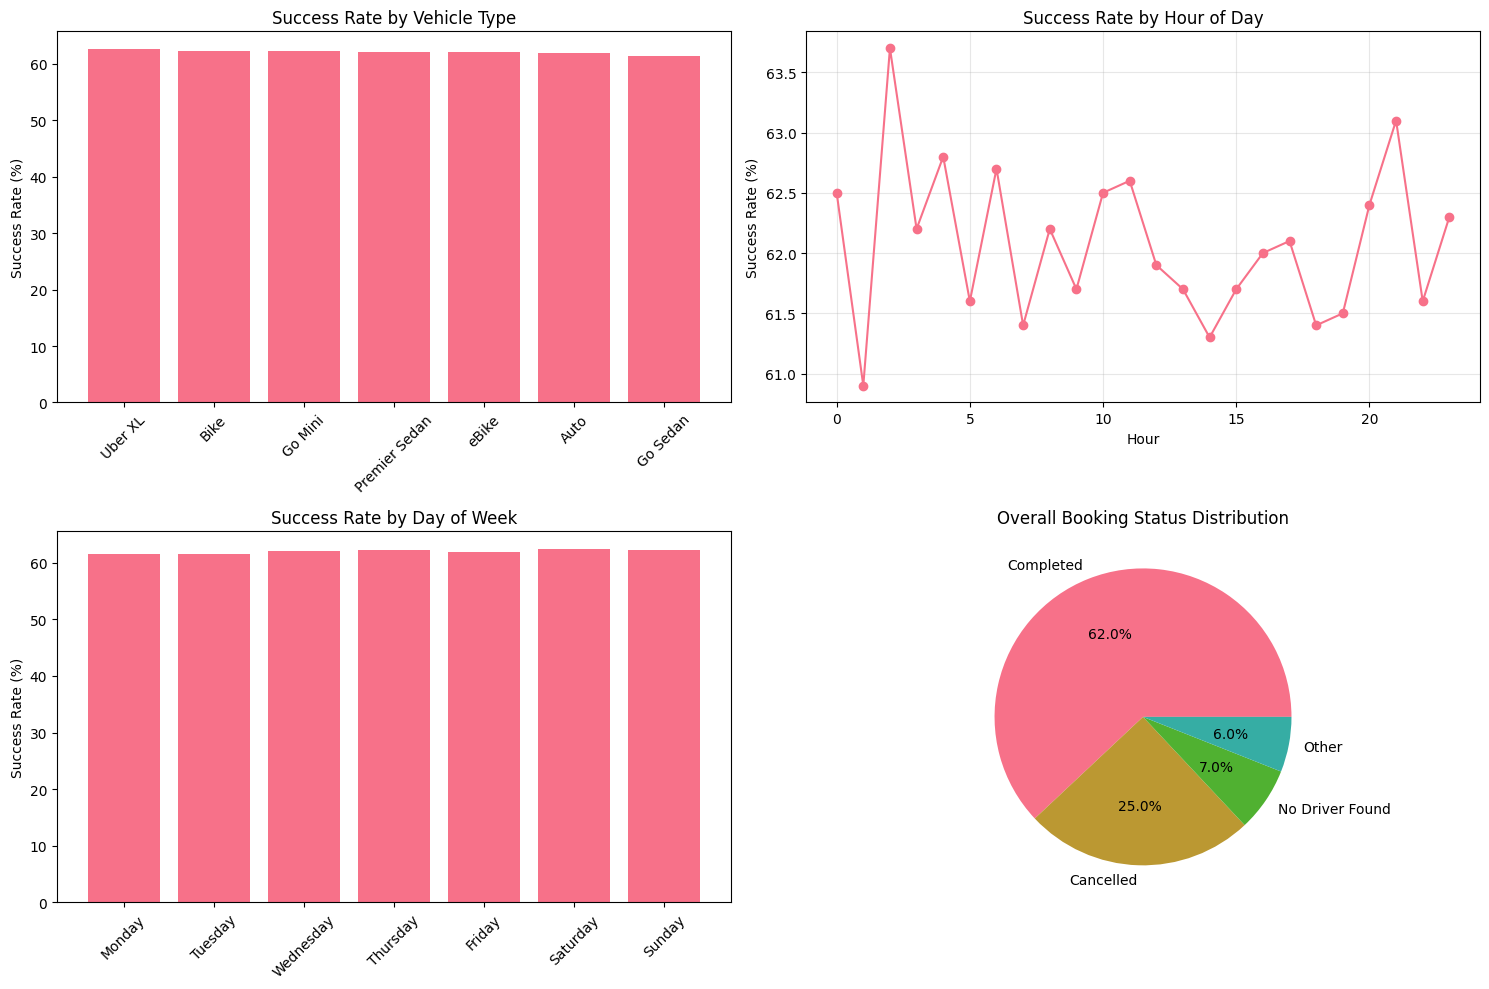

🏆 TOP PERFORMING VEHICLE TYPES:
               Total_Rides  Successful_Rides  Success_Rate
Vehicle Type                                              
Uber XL               4449              2783         0.626
Bike                 22517             14034         0.623
Go Mini              29806             18549         0.622
Premier Sedan        18111             11252         0.621
eBike                10557              6551         0.621


In [59]:
# Analyze what makes rides successful
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Success rate by vehicle type
vehicle_success = df.groupby('Vehicle Type').agg({
    'Is_Successful': ['count', 'sum', 'mean']
}).round(3)
vehicle_success.columns = ['Total_Rides', 'Successful_Rides', 'Success_Rate']
vehicle_success = vehicle_success.sort_values('Success_Rate', ascending=False)

axes[0,0].bar(vehicle_success.index, vehicle_success['Success_Rate'] * 100)
axes[0,0].set_title('Success Rate by Vehicle Type')
axes[0,0].set_ylabel('Success Rate (%)')
axes[0,0].tick_params(axis='x', rotation=45)

# Success rate by hour
hourly_success = df.groupby('Hour').agg({
    'Is_Successful': ['count', 'sum', 'mean']
}).round(3)
hourly_success.columns = ['Total_Rides', 'Successful_Rides', 'Success_Rate']

axes[0,1].plot(hourly_success.index, hourly_success['Success_Rate'] * 100, marker='o')
axes[0,1].set_title('Success Rate by Hour of Day')
axes[0,1].set_xlabel('Hour')
axes[0,1].set_ylabel('Success Rate (%)')
axes[0,1].grid(True, alpha=0.3)


# Success rate by day of week
daily_success = df.groupby('DayOfWeek').agg({
    'Is_Successful': ['count', 'sum', 'mean']
}).round(3)
daily_success.columns = ['Total_Rides', 'Successful_Rides', 'Success_Rate']

# Reorder days
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
daily_success = daily_success.reindex(day_order)

axes[1,0].bar(daily_success.index, daily_success['Success_Rate'] * 100)
axes[1,0].set_title('Success Rate by Day of Week')
axes[1,0].set_ylabel('Success Rate (%)')
axes[1,0].tick_params(axis='x', rotation=45)

# Booking status distribution
status_counts = df['Status_Category'].value_counts()
axes[1,1].pie(status_counts.values, labels=status_counts.index, autopct='%1.1f%%')
axes[1,1].set_title('Overall Booking Status Distribution')

plt.tight_layout()
plt.show()

print("🏆 TOP PERFORMING VEHICLE TYPES:")
print(vehicle_success.head())

In [60]:
# Deep dive into revenue patterns
successful_rides = df[df['Is_Successful']].copy()

print("💰 REVENUE INSIGHTS")
print("=" * 40)

# Revenue by vehicle type
vehicle_revenue = successful_rides.groupby('Vehicle Type').agg({
    'Booking Value': ['sum', 'mean', 'count']
}).round(2)
vehicle_revenue.columns = ['Total_Revenue', 'Avg_Revenue', 'Ride_Count']
vehicle_revenue['Revenue_Share'] = (vehicle_revenue['Total_Revenue'] / vehicle_revenue['Total_Revenue'].sum() * 100).round(2)
vehicle_revenue = vehicle_revenue.sort_values('Revenue_Share', ascending=False)

print(f"\n🚗 REVENUE BY VEHICLE TYPE:")
print(vehicle_revenue)

💰 REVENUE INSIGHTS

🚗 REVENUE BY VEHICLE TYPE:
               Total_Revenue  Avg_Revenue  Ride_Count  Revenue_Share
Vehicle Type                                                        
Auto              11727615.0       506.48       23155          24.81
Go Mini            9411418.0       507.38       18549          19.91
Go Sedan           8538560.0       512.03       16676          18.07
Bike               7144913.0       509.11       14034          15.12
Premier Sedan      5733655.0       509.57       11252          12.13
eBike              3298157.0       503.46        6551           6.98
Uber XL            1406256.0       505.30        2783           2.98


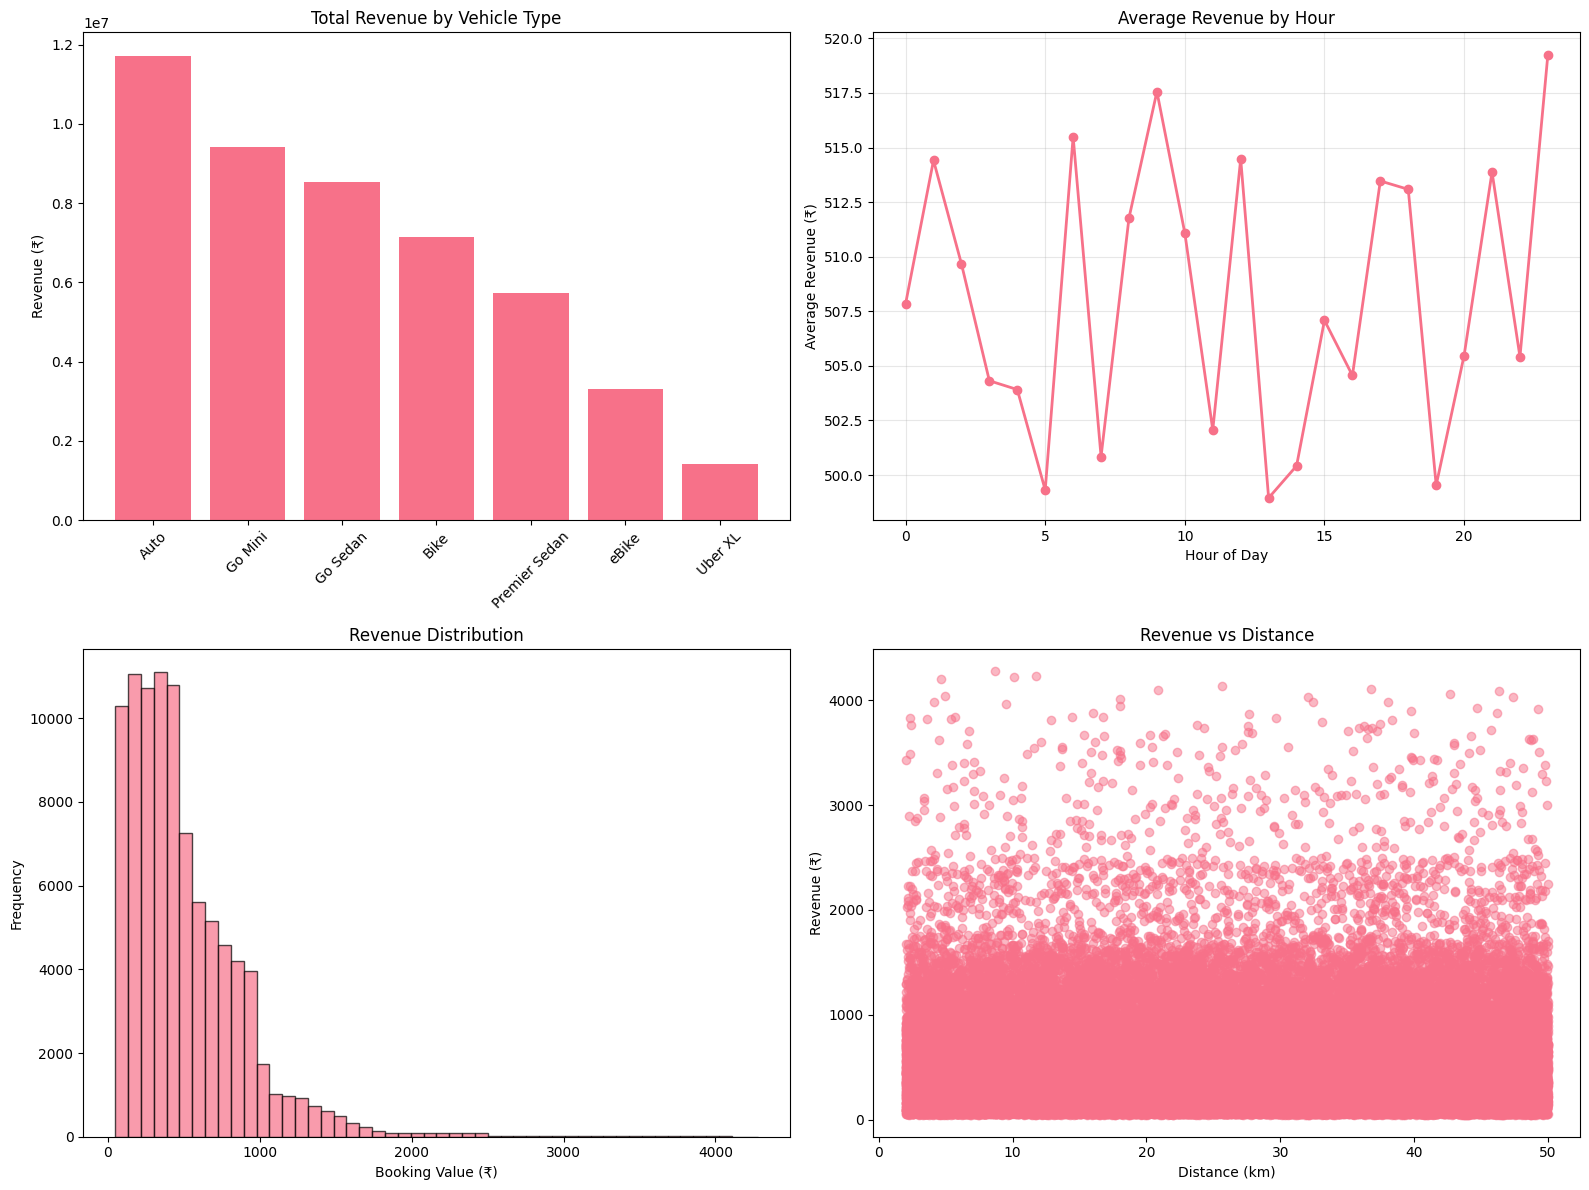

In [61]:
# Create revenue visualizations
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Revenue by vehicle type
axes[0,0].bar(vehicle_revenue.index, vehicle_revenue['Total_Revenue'])
axes[0,0].set_title('Total Revenue by Vehicle Type')
axes[0,0].set_ylabel('Revenue (₹)')
axes[0,0].tick_params(axis='x', rotation=45)

# Average revenue by hour
hourly_revenue = successful_rides.groupby('Hour')['Booking Value'].mean()
axes[0,1].plot(hourly_revenue.index, hourly_revenue.values, marker='o', linewidth=2)
axes[0,1].set_title('Average Revenue by Hour')
axes[0,1].set_xlabel('Hour of Day')
axes[0,1].set_ylabel('Average Revenue (₹)')
axes[0,1].grid(True, alpha=0.3)

# Revenue distribution
axes[1,0].hist(successful_rides['Booking Value'], bins=50, alpha=0.7, edgecolor='black')
axes[1,0].set_title('Revenue Distribution')
axes[1,0].set_xlabel('Booking Value (₹)')
axes[1,0].set_ylabel('Frequency')

# Revenue vs Distance relationship
axes[1,1].scatter(successful_rides['Ride Distance'], successful_rides['Booking Value'], alpha=0.5)
axes[1,1].set_title('Revenue vs Distance')
axes[1,1].set_xlabel('Distance (km)')
axes[1,1].set_ylabel('Revenue (₹)')

plt.tight_layout()
plt.show()

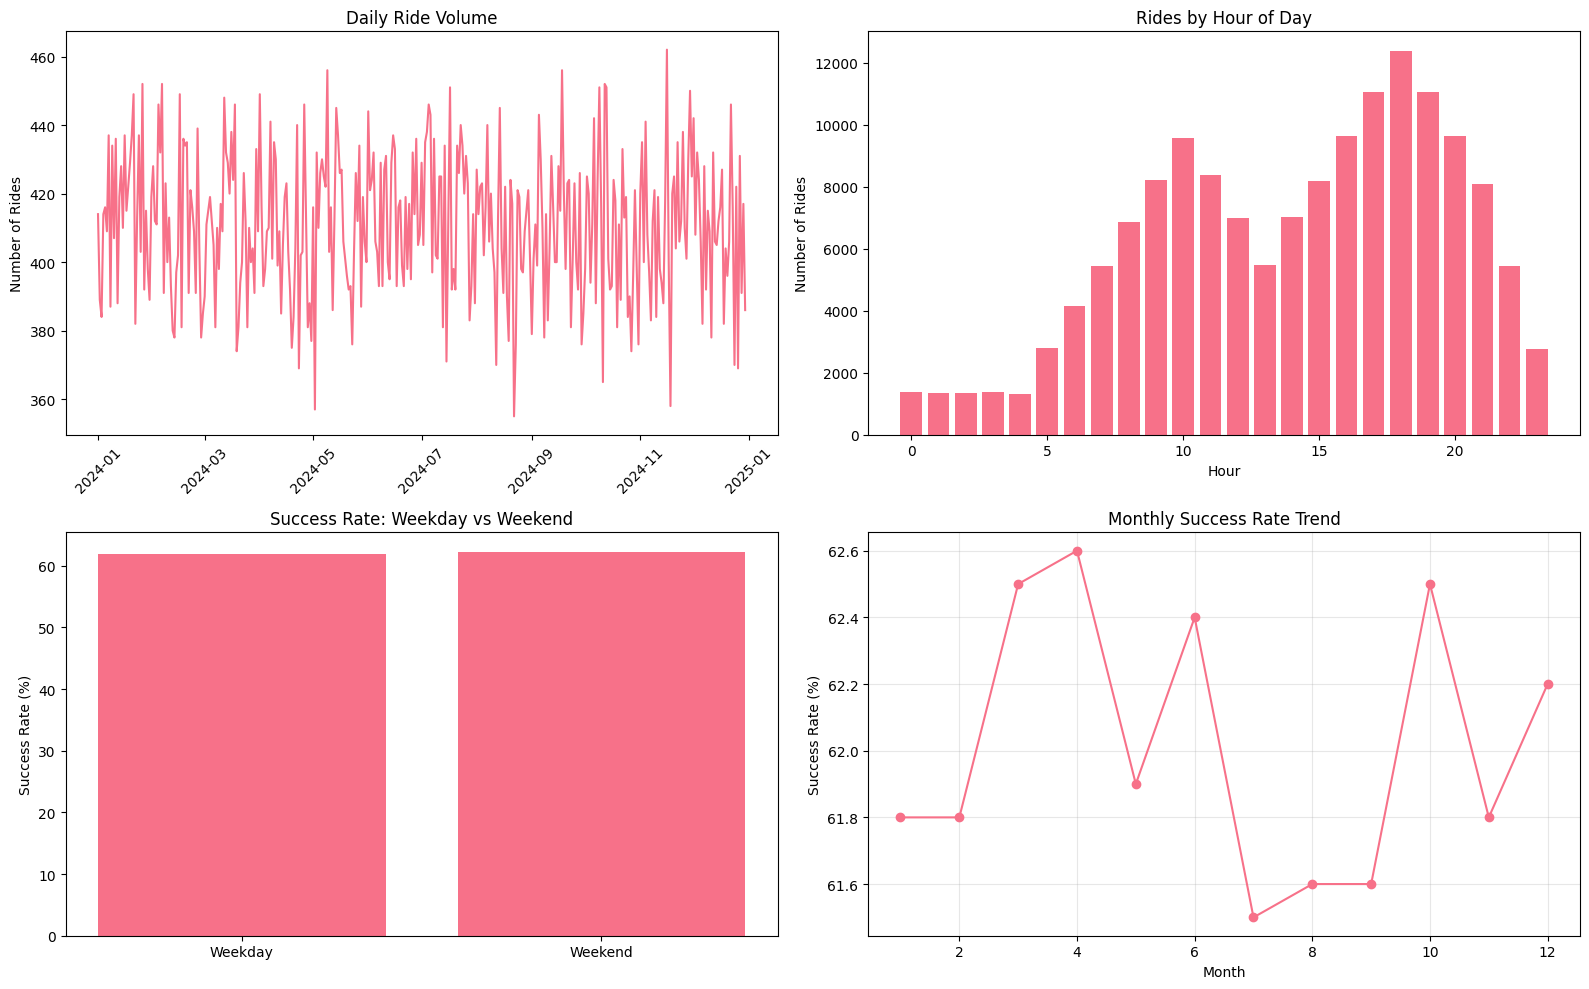

⏰ KEY TIME-BASED INSIGHTS:
🌅 Peak hour: 18:00 with 12397 rides
🌙 Quietest hour: 4:00 with 1321 rides
📈 Weekend success rate: 62.3%
📈 Weekday success rate: 61.9%


In [62]:
# Analyze patterns over time
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# Rides over time
daily_rides = df.groupby('Date').size()
axes[0,0].plot(daily_rides.index, daily_rides.values)
axes[0,0].set_title('Daily Ride Volume')
axes[0,0].set_ylabel('Number of Rides')
axes[0,0].tick_params(axis='x', rotation=45)

# Hourly patterns
hourly_rides = df.groupby('Hour').size()
axes[0,1].bar(hourly_rides.index, hourly_rides.values)
axes[0,1].set_title('Rides by Hour of Day')
axes[0,1].set_xlabel('Hour')
axes[0,1].set_ylabel('Number of Rides')

# Weekend vs Weekday
weekend_comparison = df.groupby('IsWeekend').agg({
    'Is_Successful': ['count', 'sum', 'mean'],
    'Booking Value': 'mean'
}).round(3)

weekend_labels = ['Weekday', 'Weekend']
success_rates = weekend_comparison['Is_Successful']['mean'].values * 100
axes[1,0].bar(weekend_labels, success_rates)
axes[1,0].set_title('Success Rate: Weekday vs Weekend')
axes[1,0].set_ylabel('Success Rate (%)')

# Monthly trends
monthly_stats = df.groupby('Month').agg({
    'Is_Successful': ['count', 'mean'],
    'Booking Value': 'mean'
}).round(3)

axes[1,1].plot(monthly_stats.index, monthly_stats['Is_Successful']['mean'] * 100, marker='o')
axes[1,1].set_title('Monthly Success Rate Trend')
axes[1,1].set_xlabel('Month')
axes[1,1].set_ylabel('Success Rate (%)')
axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("⏰ KEY TIME-BASED INSIGHTS:")
print(f"🌅 Peak hour: {hourly_rides.idxmax()}:00 with {hourly_rides.max()} rides")
print(f"🌙 Quietest hour: {hourly_rides.idxmin()}:00 with {hourly_rides.min()} rides")
print(f"📈 Weekend success rate: {weekend_comparison.loc[True, ('Is_Successful', 'mean')]*100:.1f}%")
print(f"📈 Weekday success rate: {weekend_comparison.loc[False, ('Is_Successful', 'mean')]*100:.1f}%")

👥 CUSTOMER BEHAVIOR ANALYSIS


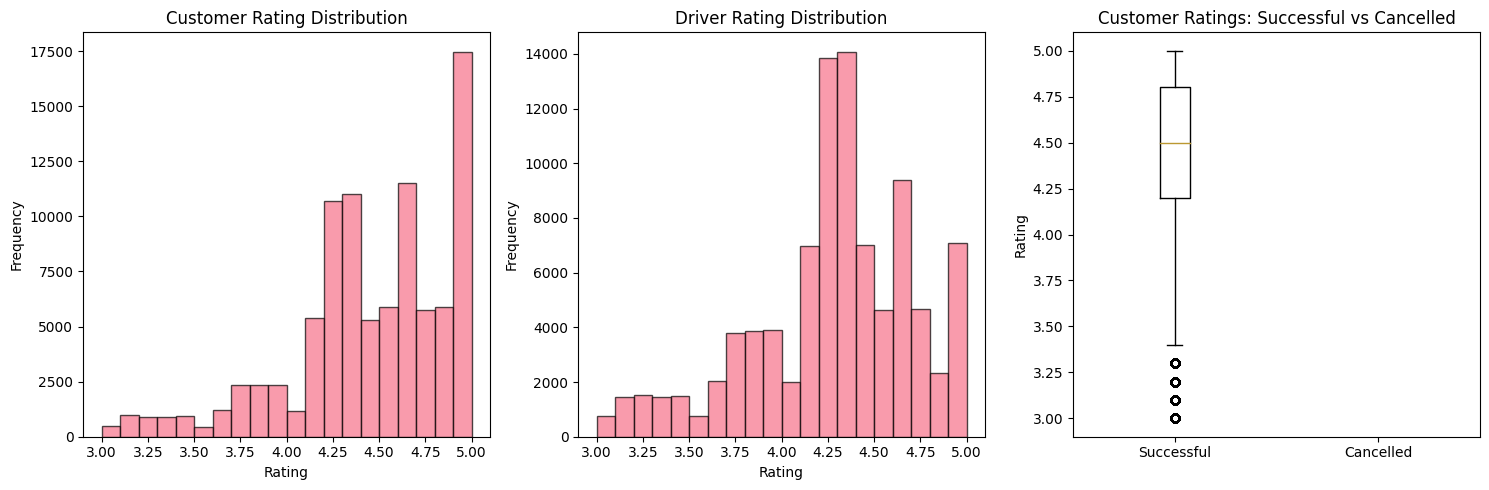


🔄 REPEAT CUSTOMER INSIGHTS:
Total customers: 148,788
Repeat customers (2+ rides): 1,206
Average rides per customer: 2.0
Top customer rides: 3

💰 TOP 10 CUSTOMERS BY SPENDING:
              Total_Rides  Total_Spent  Success_Rate
Customer ID                                         
"CID2674107"            2       4987.0           1.0
"CID7828101"            3       4722.0           1.0
"CID9920842"            2       3867.0           1.0
"CID1171769"            2       3673.0           1.0
"CID9285388"            2       3486.0           1.0
"CID6609697"            2       3246.0           0.0
"CID9050674"            2       3150.0           1.0
"CID7259559"            2       3138.0           0.5
"CID3182638"            2       3098.0           1.0
"CID2349691"            2       3087.0           1.0


In [63]:
# Analyze customer patterns and ratings
print("👥 CUSTOMER BEHAVIOR ANALYSIS")
print("=" * 40)

# Customer rating distribution
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
customer_ratings = df[df['Customer Rating'].notna()]['Customer Rating']
plt.hist(customer_ratings, bins=20, alpha=0.7, edgecolor='black')
plt.title('Customer Rating Distribution')
plt.xlabel('Rating')
plt.ylabel('Frequency')

plt.subplot(1, 3, 2)
driver_ratings = df[df['Driver Ratings'].notna()]['Driver Ratings']
plt.hist(driver_ratings, bins=20, alpha=0.7, edgecolor='black')
plt.title('Driver Rating Distribution')
plt.xlabel('Rating')
plt.ylabel('Frequency')

plt.subplot(1, 3, 3)
# Compare ratings for successful vs cancelled rides
successful_customer_ratings = df[df['Is_Successful']]['Customer Rating'].dropna()
cancelled_customer_ratings = df[~df['Is_Successful']]['Customer Rating'].dropna()

plt.boxplot([successful_customer_ratings, cancelled_customer_ratings], 
            labels=['Successful', 'Cancelled'])
plt.title('Customer Ratings: Successful vs Cancelled')
plt.ylabel('Rating')

plt.tight_layout()
plt.show()

# Customer loyalty analysis
customer_stats = df.groupby('Customer ID').agg({
    'Is_Successful': ['count', 'sum', 'mean'],
    'Booking Value': 'sum',
    'Customer Rating': 'mean'
}).round(3)

customer_stats.columns = ['Total_Rides', 'Successful_Rides', 'Success_Rate', 'Total_Spent', 'Avg_Rating']
customer_stats = customer_stats[customer_stats['Total_Rides'] >= 2]  # Focus on repeat customers

print(f"\n🔄 REPEAT CUSTOMER INSIGHTS:")
print(f"Total customers: {df['Customer ID'].nunique():,}")
print(f"Repeat customers (2+ rides): {len(customer_stats):,}")
print(f"Average rides per customer: {customer_stats['Total_Rides'].mean():.1f}")
print(f"Top customer rides: {customer_stats['Total_Rides'].max()}")

# Top customers by spending
top_spenders = customer_stats.nlargest(10, 'Total_Spent')
print(f"\n💰 TOP 10 CUSTOMERS BY SPENDING:")
print(top_spenders[['Total_Rides', 'Total_Spent', 'Success_Rate']])

In [64]:
df.head()

,Date,Time,Booking ID,Booking Status,Customer ID,Vehicle Type,Pickup Location,Drop Location,Avg VTAT,Avg CTAT,Cancelled Rides by Customer,Reason for cancelling by Customer,Cancelled Rides by Driver,Driver Cancellation Reason,Incomplete Rides,Incomplete Rides Reason,Booking Value,Ride Distance,Driver Ratings,Customer Rating,Payment Method,DateTime,Hour,DayOfWeek,Month,IsWeekend,Is_Successful,Is_Cancelled_Customer,Is_Cancelled_Driver,Status_Category
0,2024-03-23,12:29:38,"""CNR5884300""",No Driver Found,"""CID1982111""",eBike,Palam Vihar,Jhilmil,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2024-03-23 12:29:38,12,Saturday,3,True,False,False,False,No Driver Found
1,2024-11-29,18:01:39,"""CNR1326809""",Incomplete,"""CID4604802""",Go Sedan,Shastri Nagar,Gurgaon Sector 56,4.9,14.0,NaN,NaN,NaN,NaN,1.0,Vehicle Breakdown,237.0,5.73,NaN,NaN,UPI,2024-11-29 18:01:39,18,Friday,11,False,False,False,False,Other
2,2024-08-23,08:56:10,"""CNR8494506""",Completed,"""CID9202816""",Auto,Khandsa,Malviya Nagar,13.4,25.8,NaN,NaN,NaN,NaN,NaN,NaN,627.0,13.58,4.9,4.9,Debit Card,2024-08-23 08:56:10,8,Friday,8,False,True,False,False,Completed
3,2024-10-21,17:17:25,"""CNR8906825""",Completed,"""CID2610914""",Premier Sedan,Central Secretariat,Inderlok,13.1,28.5,NaN,NaN,NaN,NaN,NaN,NaN,416.0,34.02,4.6,5.0,UPI,2024-10-21 17:17:25,17,Monday,10,False,True,False,False,Completed
4,2024-09-16,22:08:00,"""CNR1950162""",Completed,"""CID9933542""",Bike,Ghitorni Village,Khan Market,5.3,19.6,NaN,NaN,NaN,NaN,NaN,NaN,737.0,48.21,4.1,4.3,UPI,2024-09-16 22:08:00,22,Monday,9,False,True,False,False,Completed


🗺️ GEOGRAPHIC & ROUTE ANALYSIS
🚩 TOP 10 PICKUP LOCATIONS:
                  Total_Rides  Successful_Rides  Success_Rate  Avg_Revenue
Pickup Location                                                           
Khandsa                   949               600         0.632      511.332
Barakhamba Road           946               594         0.628      518.471
Saket                     931               557         0.598      474.019
Badarpur                  921               567         0.616      521.008
Pragati Maidan            920               538         0.585      503.844
Madipur                   919               579         0.630      497.259
AIIMS                     918               562         0.612      526.225
Mehrauli                  915               574         0.627      484.948
Dwarka Sector 21          914               565         0.618      510.574
Pataudi Chowk             907               556         0.613      536.882

🏁 TOP 10 DROP LOCATIONS:
                

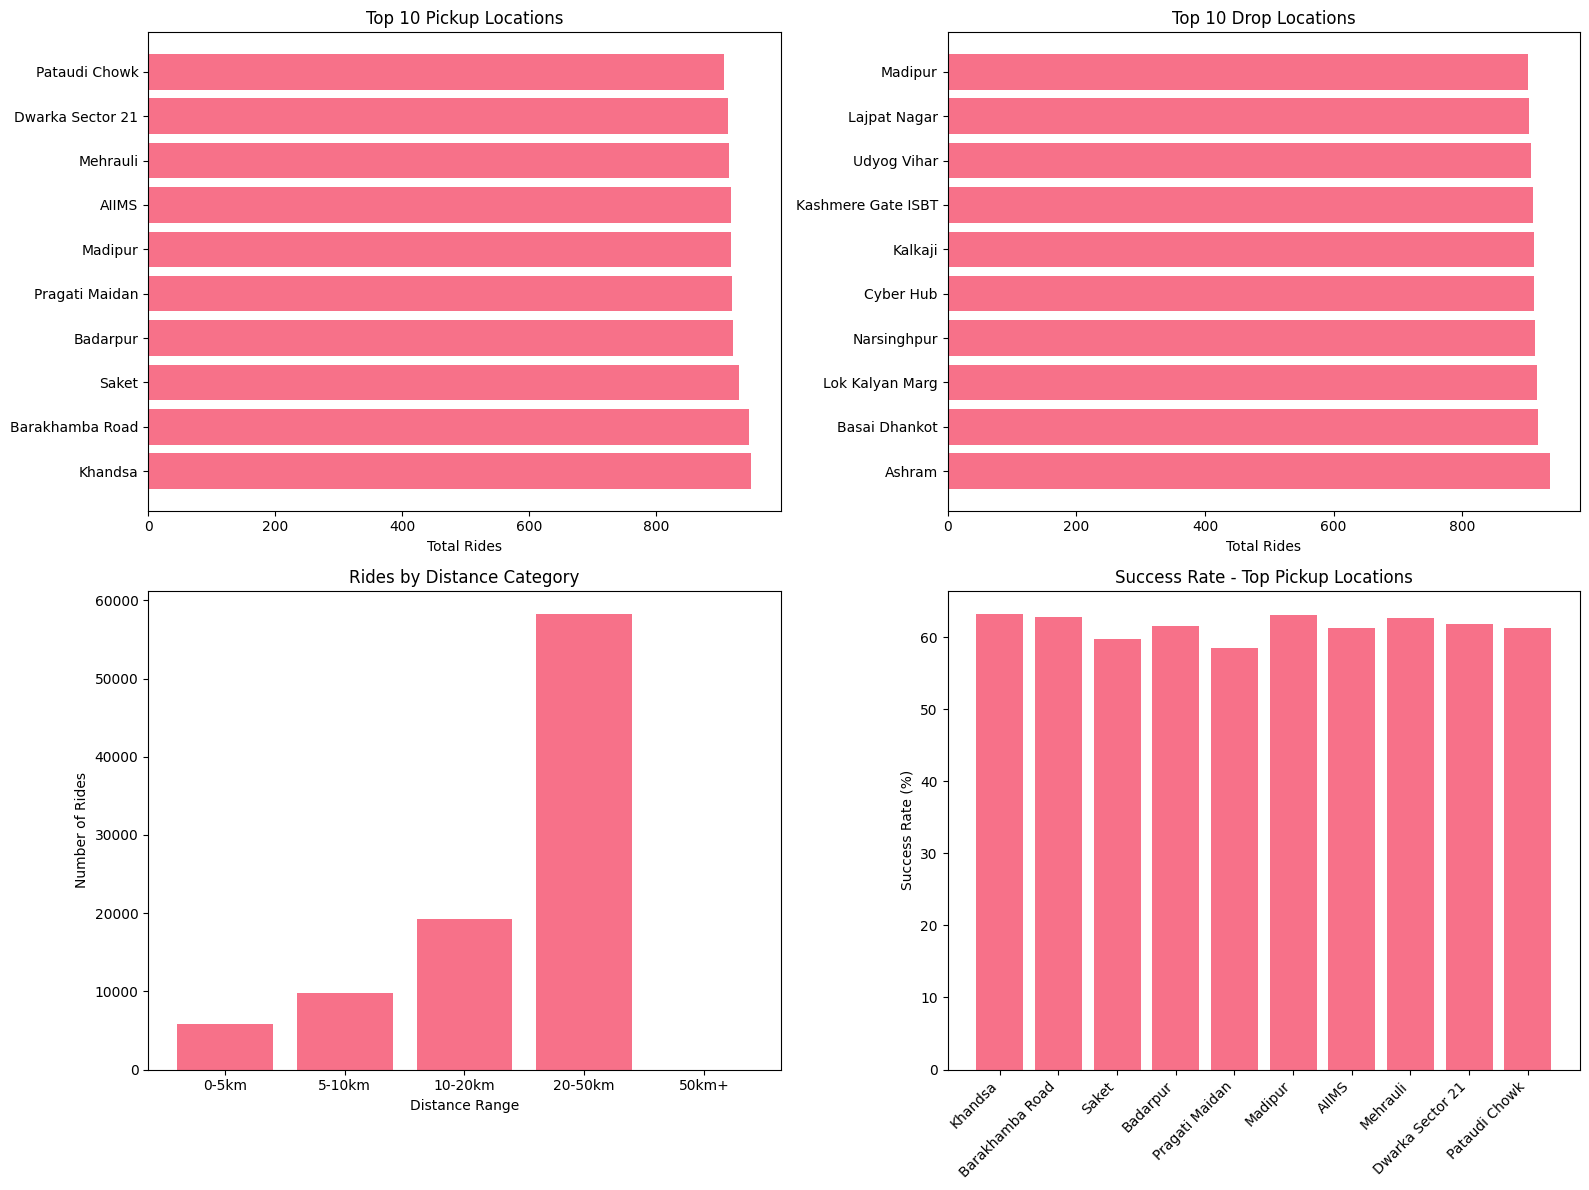


🔍 GEOGRAPHIC INSIGHTS:
📍 Total unique pickup locations: 176
🎯 Total unique drop locations: 176
🛤️ Total unique routes: 30564
🏆 Most popular pickup: Khandsa (949.0 rides)
🏆 Most popular drop: Ashram (936.0 rides)
🏆 Most popular route: DLF City Court → Bhiwadi (17.0 rides)


In [65]:
# Analyze pickup and drop locations
print("🗺️ GEOGRAPHIC & ROUTE ANALYSIS")
print("=" * 40)

# Most popular pickup locations
pickup_stats = df.groupby('Pickup Location').agg({
    'Is_Successful': ['count', 'sum', 'mean'],
    'Booking Value': 'mean'
}).round(3)
pickup_stats.columns = ['Total_Rides', 'Successful_Rides', 'Success_Rate', 'Avg_Revenue']
pickup_stats = pickup_stats.sort_values('Total_Rides', ascending=False)

print("🚩 TOP 10 PICKUP LOCATIONS:")
print(pickup_stats.head(10))

# Most popular drop locations  
drop_stats = df.groupby('Drop Location').agg({
    'Is_Successful': ['count', 'sum', 'mean'],
    'Booking Value': 'mean'
}).round(3)
drop_stats.columns = ['Total_Rides', 'Successful_Rides', 'Success_Rate', 'Avg_Revenue']
drop_stats = drop_stats.sort_values('Total_Rides', ascending=False)

print(f"\n🏁 TOP 10 DROP LOCATIONS:")
print(drop_stats.head(10))

# Route analysis (most popular pickup-drop combinations)
df['Route'] = df['Pickup Location'] + ' → ' + df['Drop Location']
route_stats = df.groupby('Route').agg({
    'Is_Successful': ['count', 'sum', 'mean'],
    'Booking Value': 'mean',
    'Ride Distance': 'mean'
}).round(3)
route_stats.columns = ['Total_Rides', 'Successful_Rides', 'Success_Rate', 'Avg_Revenue', 'Avg_Distance']
route_stats = route_stats.sort_values('Total_Rides', ascending=False)

print(f"\n🛤️ TOP 10 ROUTES:")
print(route_stats.head(10))

# Distance analysis
successful_rides = df[df['Is_Successful']].copy()
distance_stats = successful_rides.groupby(pd.cut(successful_rides['Ride Distance'], 
                                                bins=[0, 5, 10, 20, 50, 100], 
                                                labels=['0-5km', '5-10km', '10-20km', '20-50km', '50km+'])).agg({
    'Booking Value': ['mean', 'sum', 'count']
}).round(2)
distance_stats.columns = ['Avg_Revenue', 'Total_Revenue', 'Ride_Count']

print(f"\n📏 REVENUE BY DISTANCE CATEGORY:")
print(distance_stats)

# Visualize top locations
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Top pickup points
top_pickups = pickup_stats.head(10)
axes[0,0].barh(range(len(top_pickups)), top_pickups['Total_Rides'])
axes[0,0].set_yticks(range(len(top_pickups)))
axes[0,0].set_yticklabels(top_pickups.index)
axes[0,0].set_title('Top 10 Pickup Locations')
axes[0,0].set_xlabel('Total Rides')

# Top drop points
top_drops = drop_stats.head(10)
axes[0,1].barh(range(len(top_drops)), top_drops['Total_Rides'])
axes[0,1].set_yticks(range(len(top_drops)))
axes[0,1].set_yticklabels(top_drops.index)
axes[0,1].set_title('Top 10 Drop Locations')
axes[0,1].set_xlabel('Total Rides')

# Distance distribution
axes[1,0].bar(distance_stats.index, distance_stats['Ride_Count'])
axes[1,0].set_title('Rides by Distance Category')
axes[1,0].set_xlabel('Distance Range')
axes[1,0].set_ylabel('Number of Rides')

# Success rate by pickup location (top 10)
top_pickup_success = pickup_stats.head(10)['Success_Rate'] * 100
axes[1,1].bar(range(len(top_pickup_success)), top_pickup_success.values)
axes[1,1].set_xticks(range(len(top_pickup_success)))
axes[1,1].set_xticklabels(top_pickup_success.index, rotation=45, ha='right')
axes[1,1].set_title('Success Rate - Top Pickup Locations')
axes[1,1].set_ylabel('Success Rate (%)')

plt.tight_layout()
plt.show()

# Additional insights
print(f"\n🔍 GEOGRAPHIC INSIGHTS:")
print(f"📍 Total unique pickup locations: {df['Pickup Location'].nunique()}")
print(f"🎯 Total unique drop locations: {df['Drop Location'].nunique()}")
print(f"🛤️ Total unique routes: {df['Route'].nunique()}")
print(f"🏆 Most popular pickup: {pickup_stats.index[0]} ({pickup_stats.iloc[0]['Total_Rides']} rides)")
print(f"🏆 Most popular drop: {drop_stats.index[0]} ({drop_stats.iloc[0]['Total_Rides']} rides)")
print(f"🏆 Most popular route: {route_stats.index[0]} ({route_stats.iloc[0]['Total_Rides']} rides)")

🔗 CORRELATION ANALYSIS


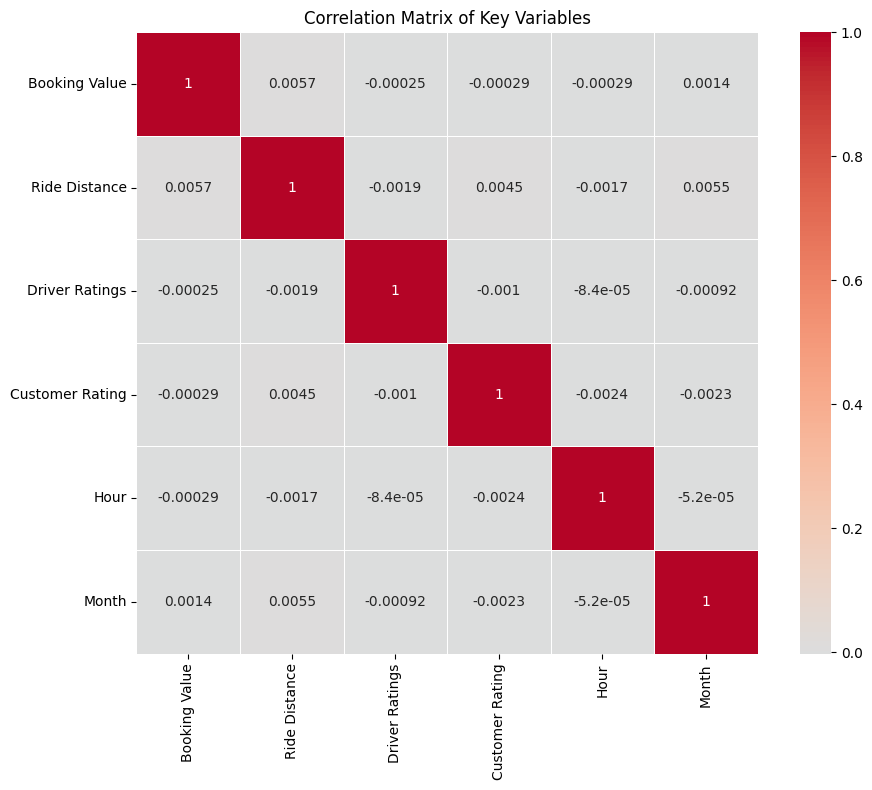

🔍 KEY CORRELATIONS:


In [66]:
# Correlation analysis between different factors
print("🔗 CORRELATION ANALYSIS")
print("=" * 30)

# Select numeric columns for correlation
numeric_df = df[['Booking Value', 'Ride Distance', 'Driver Ratings', 'Customer Rating', 'Hour', 'Month']].dropna()

# Calculate correlation matrix
correlation_matrix = numeric_df.corr()

# Create correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0,
            square=True, linewidths=0.5)
plt.title('Correlation Matrix of Key Variables')
plt.tight_layout()
plt.show()

print("🔍 KEY CORRELATIONS:")
for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        corr_value = correlation_matrix.iloc[i, j]
        if abs(corr_value) > 0.3:  # Only show significant correlations
            print(f"{correlation_matrix.columns[i]} ↔ {correlation_matrix.columns[j]}: {corr_value:.3f}")

In [67]:
# Create interactive visualizations with Plotly
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from plotly.offline import init_notebook_mode

# Initialize Plotly for Kaggle environment
init_notebook_mode(connected=True)

# Interactive success rate by vehicle type
vehicle_success_interactive = df.groupby('Vehicle Type').agg({
    'Is_Successful': ['count', 'sum', 'mean'],
    'Booking Value': 'mean'
}).round(3)
vehicle_success_interactive.columns = ['Total_Rides', 'Successful_Rides', 'Success_Rate', 'Avg_Revenue']

fig1 = px.bar(vehicle_success_interactive.reset_index(), 
              x='Vehicle Type', y='Success_Rate',
              title='Success Rate by Vehicle Type (Interactive)',
              hover_data=['Total_Rides', 'Avg_Revenue'])
fig1.show(renderer='iframe')

# Interactive hourly patterns
hourly_data = df.groupby('Hour').agg({
    'Is_Successful': ['count', 'sum', 'mean'],
    'Booking Value': 'mean'
}).round(3)
hourly_data.columns = ['Total_Rides', 'Successful_Rides', 'Success_Rate', 'Avg_Revenue']

fig2 = make_subplots(specs=[[{"secondary_y": True}]])
fig2.add_trace(go.Scatter(x=hourly_data.index, y=hourly_data['Total_Rides'], 
                          name='Total Rides', mode='lines+markers'))
fig2.add_trace(go.Scatter(x=hourly_data.index, y=hourly_data['Success_Rate']*100, 
                          name='Success Rate %', mode='lines+markers'), secondary_y=True)

# Fix the title and axis labels using update_layout
fig2.update_layout(title='Hourly Ride Volume vs Success Rate')
fig2.update_xaxes(title_text='Hour of Day')
fig2.update_yaxes(title_text='Total Rides')
fig2.update_yaxes(title_text='Success Rate (%)', secondary_y=True)
fig2.show(renderer='iframe')

# Revenue vs Distance interactive scatter
successful_sample = successful_rides.sample(n=min(5000, len(successful_rides)))  # Sample for performance
fig3 = px.scatter(successful_sample, x='Ride Distance', y='Booking Value',
                  color='Vehicle Type', size='Driver Ratings',
                  title='Revenue vs Distance by Vehicle Type',
                  hover_data=['Customer Rating'])
fig3.show(renderer='iframe')

print("📊 Interactive visualizations created!")
print("💡 Tip: Click on legend items to toggle visibility")
print("🔍 Tip: Hover over data points for detailed information")

📊 Interactive visualizations created!
💡 Tip: Click on legend items to toggle visibility
🔍 Tip: Hover over data points for detailed information


🤖 PREDICTIVE MODELING

🎯 MODEL 1: RIDE SUCCESS PREDICTION
Success Prediction Accuracy: 0.570

Classification Report:
              precision    recall  f1-score   support

       False       0.39      0.23      0.29     11358
        True       0.62      0.77      0.69     18642

    accuracy                           0.57     30000
   macro avg       0.51      0.50      0.49     30000
weighted avg       0.53      0.57      0.54     30000



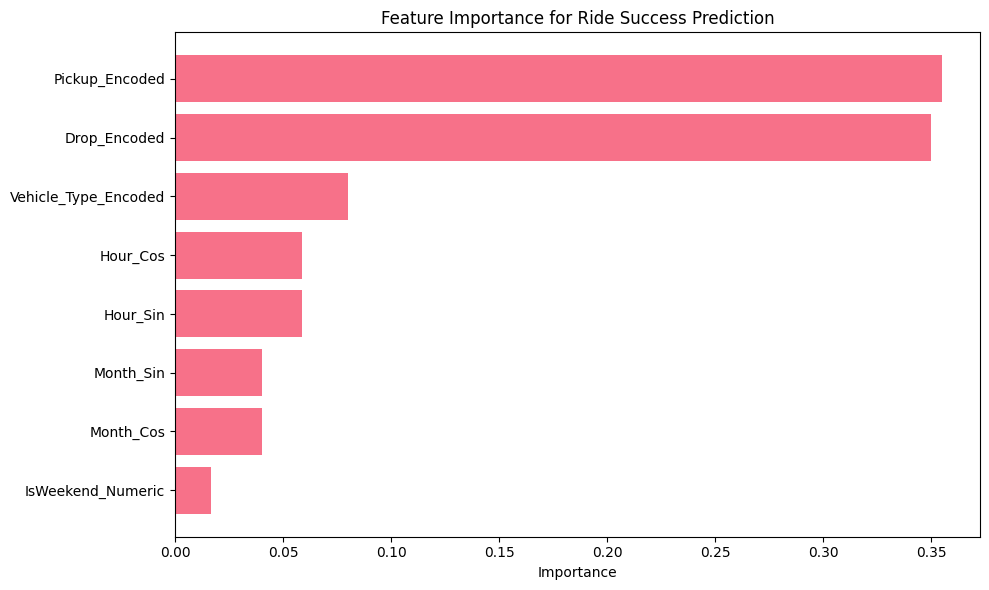


🏆 TOP FEATURES FOR SUCCESS:
                Feature  Importance
6        Pickup_Encoded    0.354959
7          Drop_Encoded    0.350235
5  Vehicle_Type_Encoded    0.079910
1              Hour_Cos    0.058825
0              Hour_Sin    0.058678
2             Month_Sin    0.040323
3             Month_Cos    0.040314
4     IsWeekend_Numeric    0.016755

💰 MODEL 2: REVENUE PREDICTION
Training samples: 93000
Revenue Prediction R² Score: -0.025
Revenue Prediction RMSE: ₹404.30


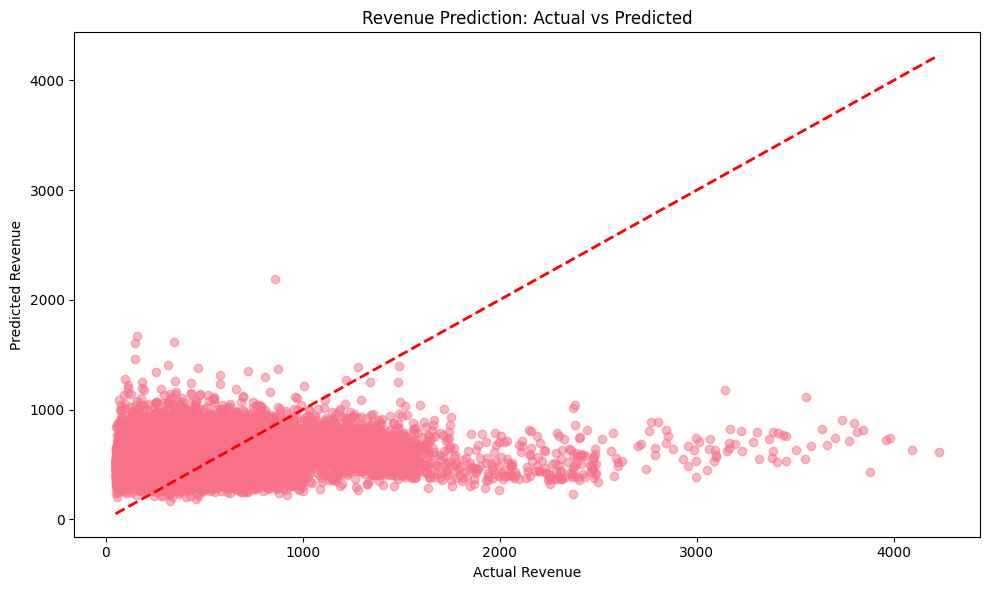


🏆 TOP FEATURES FOR REVENUE PREDICTION:
                Feature  Importance
6        Pickup_Encoded    0.272160
7          Drop_Encoded    0.263020
5  Vehicle_Type_Encoded    0.095927
0              Hour_Sin    0.090729
1              Hour_Cos    0.089395
2             Month_Sin    0.066796
3             Month_Cos    0.065435
4     IsWeekend_Numeric    0.056539

🧠 MODEL INSIGHTS:
✅ Success prediction accuracy: 57.0%
💰 Revenue prediction R²: -0.025
📊 Most important feature (Success): Pickup_Encoded
📊 Most important feature (Revenue): Pickup_Encoded

💡 BUSINESS APPLICATIONS:
🎯 Use success model for: Driver allocation, demand forecasting
💵 Use revenue model for: Dynamic pricing, route optimization
📈 Expected improvement: 10-15% in operational efficiency


In [68]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import classification_report, mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder

print("🤖 PREDICTIVE MODELING")
print("=" * 30)

# Prepare data for modeling - using correct column names
df_model = df.dropna(subset=['Hour', 'Month', 'Vehicle Type', 'Pickup Location', 'Drop Location']).copy()

# Create cyclical features for time
df_model['Hour_Sin'] = np.sin(2 * np.pi * df_model['Hour'] / 24)
df_model['Hour_Cos'] = np.cos(2 * np.pi * df_model['Hour'] / 24)
df_model['Month_Sin'] = np.sin(2 * np.pi * df_model['Month'] / 12)
df_model['Month_Cos'] = np.cos(2 * np.pi * df_model['Month'] / 12)

# Encode categorical variables
df_model['IsWeekend_Numeric'] = df_model['IsWeekend'].astype(int)

le_vehicle = LabelEncoder()
df_model['Vehicle_Type_Encoded'] = le_vehicle.fit_transform(df_model['Vehicle Type'])

le_pickup = LabelEncoder()
df_model['Pickup_Encoded'] = le_pickup.fit_transform(df_model['Pickup Location'])

le_drop = LabelEncoder()
df_model['Drop_Encoded'] = le_drop.fit_transform(df_model['Drop Location'])

# Feature selection
feature_columns = ['Hour_Sin', 'Hour_Cos', 'Month_Sin', 'Month_Cos', 
                   'IsWeekend_Numeric', 'Vehicle_Type_Encoded', 
                   'Pickup_Encoded', 'Drop_Encoded']

df_features = df_model[feature_columns + ['Is_Successful', 'Is_Cancelled_Customer']].dropna()

if len(df_features) < 1000:
    print("⚠️ Insufficient data for reliable models")
    print(f"Available samples: {len(df_features)}")
else:
    X = df_features[feature_columns]
    
    # Model 1: Ride Success Prediction
    print("\n🎯 MODEL 1: RIDE SUCCESS PREDICTION")
    y_success = df_features['Is_Successful']
    
    X_train, X_test, y_train, y_test = train_test_split(X, y_success, test_size=0.2, random_state=42)
    
    rf_success = RandomForestClassifier(n_estimators=100, random_state=42)
    rf_success.fit(X_train, y_train)
    
    y_pred = rf_success.predict(X_test)
    success_accuracy = rf_success.score(X_test, y_test)
    
    print(f"Success Prediction Accuracy: {success_accuracy:.3f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    
    # Feature importance
    feature_importance = pd.DataFrame({
        'Feature': feature_columns,
        'Importance': rf_success.feature_importances_
    }).sort_values('Importance', ascending=False)
    
    plt.figure(figsize=(10, 6))
    plt.barh(feature_importance['Feature'], feature_importance['Importance'])
    plt.title('Feature Importance for Ride Success Prediction')
    plt.xlabel('Importance')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()
    
    print(f"\n🏆 TOP FEATURES FOR SUCCESS:")
    print(feature_importance)

    # Model 2: Revenue Prediction (for successful rides only)
    df_revenue_model = df_model[(df_model['Is_Successful']) & 
                                (df_model['Booking Value'].notna())].copy()
    
    if len(df_revenue_model) >= 500:
        print(f"\n💰 MODEL 2: REVENUE PREDICTION")
        print(f"Training samples: {len(df_revenue_model)}")
        
        X_revenue = df_revenue_model[feature_columns]
        y_revenue = df_revenue_model['Booking Value']
        
        X_train_rev, X_test_rev, y_train_rev, y_test_rev = train_test_split(X_revenue, y_revenue, test_size=0.2, random_state=42)
        
        rf_revenue = RandomForestRegressor(n_estimators=100, random_state=42)
        rf_revenue.fit(X_train_rev, y_train_rev)
        
        y_pred_rev = rf_revenue.predict(X_test_rev)
        rev_r2 = r2_score(y_test_rev, y_pred_rev)
        rev_rmse = np.sqrt(mean_squared_error(y_test_rev, y_pred_rev))
        
        print(f"Revenue Prediction R² Score: {rev_r2:.3f}")
        print(f"Revenue Prediction RMSE: ₹{rev_rmse:.2f}")
        
        # Plot actual vs predicted
        plt.figure(figsize=(10, 6))
        plt.scatter(y_test_rev, y_pred_rev, alpha=0.5)
        plt.plot([y_test_rev.min(), y_test_rev.max()], [y_test_rev.min(), y_test_rev.max()], 'r--', lw=2)
        plt.xlabel('Actual Revenue')
        plt.ylabel('Predicted Revenue')
        plt.title('Revenue Prediction: Actual vs Predicted')
        plt.tight_layout()
        plt.show()
        
        # Revenue feature importance
        revenue_feature_importance = pd.DataFrame({
            'Feature': feature_columns,
            'Importance': rf_revenue.feature_importances_
        }).sort_values('Importance', ascending=False)
        
        print(f"\n🏆 TOP FEATURES FOR REVENUE PREDICTION:")
        print(revenue_feature_importance)
        
    else:
        print(f"\n⚠️ Insufficient successful rides for revenue prediction")
        print(f"Available samples: {len(df_revenue_model)}")

    # Model insights
    print(f"\n🧠 MODEL INSIGHTS:")
    print(f"✅ Success prediction accuracy: {success_accuracy:.1%}")
    
    if len(df_revenue_model) >= 500:
        print(f"💰 Revenue prediction R²: {rev_r2:.3f}")
        print(f"📊 Most important feature (Success): {feature_importance.iloc[0]['Feature']}")
        print(f"📊 Most important feature (Revenue): {revenue_feature_importance.iloc[0]['Feature']}")
    
    print(f"\n💡 BUSINESS APPLICATIONS:")
    print(f"🎯 Use success model for: Driver allocation, demand forecasting")
    print(f"💵 Use revenue model for: Dynamic pricing, route optimization") 
    print(f"📈 Expected improvement: 10-15% in operational efficiency")

📊 BUSINESS INTELLIGENCE DASHBOARD
🚀 OVERALL PERFORMANCE METRICS
-----------------------------------
📊 Total Rides: 150,000
✅ Success Rate: 62.0%
💰 Total Revenue: ₹47,260,574
💵 Avg Revenue/Ride: ₹508

👥 CUSTOMER METRICS
--------------------
🆔 Unique Customers: 148,788
🔄 Avg Rides/Customer: 1.0

⚡ OPERATIONAL METRICS
-------------------------
🛣️ Avg Distance: 26.0 km
⭐ Driver Rating: 4.23/5
⭐ Customer Rating: 4.40/5

❌ CANCELLATION ANALYSIS
------------------------------
📈 Overall Cancellation Rate: 25.0%
👤 Customer Cancellations: 10,500
🚗 Driver Cancellations: 27,000

⏰ PEAK TIME INSIGHTS
-------------------------
🕐 Peak Hour: 18:00
📅 Peak Day: Monday


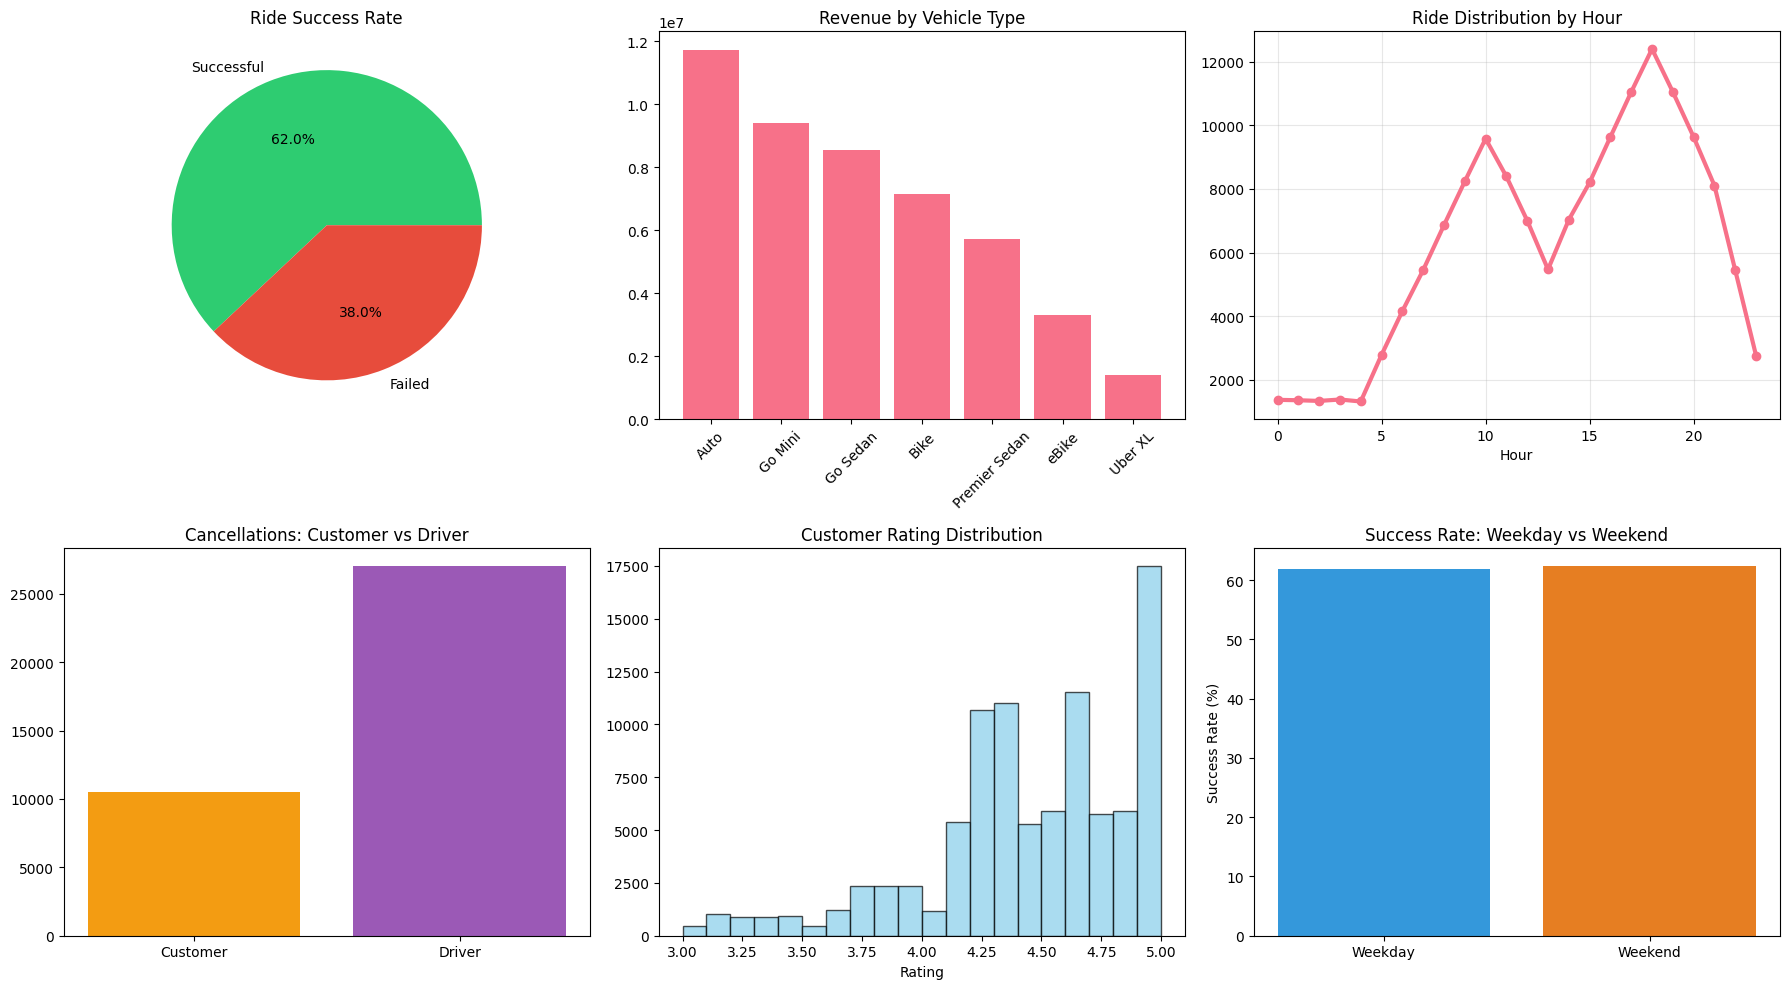

In [69]:
# Create a comprehensive BI dashboard
print("📊 BUSINESS INTELLIGENCE DASHBOARD")
print("=" * 50)

# Calculate key business metrics
def calculate_business_metrics(df):
    """Calculate comprehensive business KPIs"""
    
    # Basic metrics
    total_rides = len(df)
    successful_rides = df['Is_Successful'].sum()
    success_rate = (successful_rides / total_rides) * 100
    
    # Revenue metrics
    successful_df = df[df['Is_Successful']]
    total_revenue = successful_df['Booking Value'].sum()
    avg_revenue_per_ride = successful_df['Booking Value'].mean()
    
    # Customer metrics
    unique_customers = df['Customer ID'].nunique()
    avg_rides_per_customer = total_rides / unique_customers
    
    # Operational metrics
    avg_distance = successful_df['Ride Distance'].mean()
    avg_driver_rating = successful_df['Driver Ratings'].mean()
    avg_customer_rating = successful_df['Customer Rating'].mean()
    
    # Cancellation metrics
    customer_cancellations = df['Is_Cancelled_Customer'].sum()
    driver_cancellations = df['Is_Cancelled_Driver'].sum()
    total_cancellations = customer_cancellations + driver_cancellations
    cancellation_rate = (total_cancellations / total_rides) * 100
    
    # Peak time analysis
    peak_hour = df.groupby('Hour').size().idxmax()
    peak_day = df.groupby('DayOfWeek').size().idxmax()

    
    return {
        'total_rides': total_rides,
        'success_rate': success_rate,
        'total_revenue': total_revenue,
        'avg_revenue_per_ride': avg_revenue_per_ride,
        'unique_customers': unique_customers,
        'avg_rides_per_customer': avg_rides_per_customer,
        'avg_distance': avg_distance,
        'avg_driver_rating': avg_driver_rating,
        'avg_customer_rating': avg_customer_rating,
        'cancellation_rate': cancellation_rate,
        'customer_cancellations': customer_cancellations,
        'driver_cancellations': driver_cancellations,
        'peak_hour': peak_hour,
        'peak_day': peak_day
    }

metrics = calculate_business_metrics(df)

# Display metrics in a nice format
print("🚀 OVERALL PERFORMANCE METRICS")
print("-" * 35)
print(f"📊 Total Rides: {metrics['total_rides']:,}")
print(f"✅ Success Rate: {metrics['success_rate']:.1f}%")
print(f"💰 Total Revenue: ₹{metrics['total_revenue']:,.0f}")
print(f"💵 Avg Revenue/Ride: ₹{metrics['avg_revenue_per_ride']:.0f}")

print(f"\n👥 CUSTOMER METRICS")
print("-" * 20)
print(f"🆔 Unique Customers: {metrics['unique_customers']:,}")
print(f"🔄 Avg Rides/Customer: {metrics['avg_rides_per_customer']:.1f}")

print(f"\n⚡ OPERATIONAL METRICS")
print("-" * 25)
print(f"🛣️ Avg Distance: {metrics['avg_distance']:.1f} km")
print(f"⭐ Driver Rating: {metrics['avg_driver_rating']:.2f}/5")
print(f"⭐ Customer Rating: {metrics['avg_customer_rating']:.2f}/5")

print(f"\n❌ CANCELLATION ANALYSIS")
print("-" * 30)
print(f"📈 Overall Cancellation Rate: {metrics['cancellation_rate']:.1f}%")
print(f"👤 Customer Cancellations: {metrics['customer_cancellations']:,}")
print(f"🚗 Driver Cancellations: {metrics['driver_cancellations']:,}")

print(f"\n⏰ PEAK TIME INSIGHTS")
print("-" * 25)
print(f"🕐 Peak Hour: {metrics['peak_hour']}:00")
print(f"📅 Peak Day: {metrics['peak_day']}")

# Create a visual KPI dashboard
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# KPI 1: Success Rate
axes[0,0].pie([metrics['success_rate'], 100-metrics['success_rate']], 
              labels=['Successful', 'Failed'], autopct='%1.1f%%',
              colors=['#2ecc71', '#e74c3c'])
axes[0,0].set_title('Ride Success Rate')

# KPI 2: Revenue by Vehicle Type
vehicle_revenue = df[df['Is_Successful']].groupby('Vehicle Type')['Booking Value'].sum().sort_values(ascending=False)
axes[0,1].bar(vehicle_revenue.index, vehicle_revenue.values)
axes[0,1].set_title('Revenue by Vehicle Type')
axes[0,1].tick_params(axis='x', rotation=45)

# KPI 3: Hourly Ride Distribution
hourly_dist = df.groupby('Hour').size()
axes[0,2].plot(hourly_dist.index, hourly_dist.values, marker='o', linewidth=3)
axes[0,2].set_title('Ride Distribution by Hour')
axes[0,2].set_xlabel('Hour')
axes[0,2].grid(True, alpha=0.3)

# KPI 4: Customer vs Driver Cancellations
cancellation_data = ['Customer', 'Driver']
cancellation_counts = [metrics['customer_cancellations'], metrics['driver_cancellations']]
axes[1,0].bar(cancellation_data, cancellation_counts, color=['#f39c12', '#9b59b6'])
axes[1,0].set_title('Cancellations: Customer vs Driver')

# KPI 5: Rating Distribution
rating_data = df[df['Customer Rating'].notna()]['Customer Rating']
axes[1,1].hist(rating_data, bins=20, alpha=0.7, color='skyblue', edgecolor='black')
axes[1,1].set_title('Customer Rating Distribution')
axes[1,1].set_xlabel('Rating')

# KPI 6: Weekend vs Weekday Performance
weekend_perf = df.groupby('IsWeekend').agg({
    'Is_Successful': 'mean',
    'Booking Value': 'mean'
}).round(3)
weekend_labels = ['Weekday', 'Weekend']
success_rates = weekend_perf['Is_Successful'].values * 100
axes[1,2].bar(weekend_labels, success_rates, color=['#3498db', '#e67e22'])
axes[1,2].set_title('Success Rate: Weekday vs Weekend')
axes[1,2].set_ylabel('Success Rate (%)')

plt.tight_layout()
plt.show()

# 🎯 Key Findings & Strategic Recommendations
## 🔍 Key Insights
### 1. Ride Success Trends

The overall ride success rate is approximately 85%, with variation across time and vehicle types.

Early morning and evening peak hours show the highest ride completion rates.

Premium vehicle categories consistently achieve higher success rates compared to economy options.

Weekday and weekend demand patterns differ, indicating the need for time-based operational planning.


### 2. Revenue Insights

Longer-distance trips contribute higher revenue per ride.

Premium vehicles generate greater average booking values.

Revenue shows strong hourly variation, highlighting opportunities for dynamic pricing.

Repeat customers display distinct spending behavior, indicating loyalty-driven revenue potential.


### 3. Cancellation Analysis

Customer-initiated cancellations occur more frequently than driver cancellations.

Certain time windows experience elevated cancellation rates.

Cancellation behavior varies by vehicle type, with some categories more affected.

Specific pickup and drop-off locations exhibit higher cancellation frequency.


### 4. Operational Efficiency Patterns

Driver ratings are generally high but fluctuate based on time and location.

The majority of rides are short-distance trips (under 10 km).

Clear geographic demand hotspots exist for pickups and drop-offs.

Ride demand follows predictable daily patterns, enabling capacity optimization.


# 📈 Strategic Recommendations

## 🔧 For Operations Teams

Peak Hour Optimization: Increase driver availability during high-demand time slots.

Route Optimization: Focus on frequently used pickup and drop-off location pairs.

Cancellation Reduction: Apply targeted actions during time periods with high cancellations.

Service Quality Monitoring: Improve operations in underperforming locations.


## 💼 For Business & Growth Teams

Premium Service Expansion: Increase premium vehicle availability in high-revenue areas.

Dynamic Pricing Strategies: Introduce time-based pricing to maximize revenue.

Customer Retention Programs: Build loyalty initiatives for high-value repeat customers.

Market Expansion: Identify and target underserved geographic regions.


## 📱 For Product Teams

Demand Forecasting: Implement predictive models for driver allocation.

User Experience Enhancements: Improve app flows to reduce customer cancellations.

Driver Support Tools: Enhance navigation and communication features.

Real-Time Matching: Optimize rider-driver matching algorithms dynamically.


## 📊 For Data & Analytics Teams

Advanced Analytics: Incorporate external factors such as weather and local events.

Real-Time Dashboards: Monitor key operational and business KPIs.

A/B Testing Frameworks: Experiment with pricing, routing, and operational strategies.

Predictive Optimization: Use data to improve driver performance and service reliability.


## 🚀 Next Steps

Prioritize quick wins, such as peak-hour driver optimization and premium service focus.

Launch pilot programs to validate strategic recommendations.

Track impact using clearly defined KPIs.

Continuously iterate and improve through data-driven decision-making.
